In [1]:
import pandas as pd
from scipy import stats
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

%matplotlib inline

/Library/Python/2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
df = pd.read_csv('events_log_.csv', parse_dates=['timestamp'], index_col='timestamp')

In [32]:
def CRT(df):
    clickthroughrate = float(len(df['action'][df['action'] == 'visitPage'])) / float(len(df['action'][df['action'] == 'searchResultPage']))
    return clickthroughrate

def ZeroResultsRate(df):
    zero_results_rate = (float(len(d['n_results'][d['n_results'] == 0])) / float(len(d['action'][d['action'] == 'searchResultPage'])))
    return zero_results_rate

def bars(list_means, list_errors, title, ylabel):
    bar_width = 0.35
    
    index = np.arange(3)
    rects = ax.bar(range(len(list_means)), list_means, bar_width, color='k', yerr=list_errors, alpha=0.5, error_kw=dict(ecolor='black', lw=2, capsize=5, capthick=2))

    plt.title(title,size=15)
    plt.xticks(index + bar_width / 2,('Overall', 'Group A','Group B'),size=13)
    plt.ylabel(ylabel,size=13)
    plt.yticks(np.round(np.linspace(0,max(list_means)+0.05,6),1),size=13)
    plt.legend()
    
def pairs_bars(series_A, series_B, title, ylabel):
    bar_width = 0.35
    index = np.arange(8)
    rects1 = plt.bar(index, series_A, bar_width,
                     alpha=0.5,
                     color='b',
                     label='A')
    rects2 = plt.bar(index + bar_width, series_B, bar_width,
                     alpha=0.5,
                     color='r',
                     label='B')

    plt.title(title, size=15)
    plt.ylim([0, 1])
    plt.ylabel(ylabel, size=13)
    plt.xlabel('Day', size=13)
    plt.xticks(index + bar_width / 2, ('1', '2', '3', '4', '5','6','7','8'))

    plt.tight_layout()
    plt.legend()
    
def get_mean_error(overall, groupA, groupB):
    
    mean_o = sum(overall)/len(overall)
    mean_A = sum(groupA)/len(groupA)
    mean_B = sum(groupB)/len(groupB)

    error_o = stats.sem(overall)
    error_A = stats.sem(groupA)
    error_B = stats.sem(groupB)
    
    mean_ = [mean_o, mean_A, mean_B]
    error_ = [error_o, error_A, error_B]
    
    return mean_,error_

def get_session_length(dataframe):
    first_action = dataframe.sort_index().groupby(['session_id'], sort=True, as_index=False).nth(0).drop(['uuid','page_id','Unnamed: 0'],axis=1)
    first_action['time'] = first_action.index.to_pydatetime()
    last_action = dataframe.sort_index().groupby(['session_id'], as_index=False, sort=True).nth(-1).drop(['page_id','uuid','Unnamed: 0'],axis=1)
    last_action['time'] = last_action.index.to_pydatetime()
    last_action.sort_values('session_id').head()
    session_start_end = pd.merge(first_action, last_action, on = ['session_id','group'], suffixes=('_first_action','_last_action'))
    session_start_end['session_length'] = session_start_end['time_last_action'] - session_start_end['time_first_action']
    session_start_end['session_lenght_seconds'] = session_start_end['session_length'].apply(lambda row: row.seconds)
    return session_start_end

In [19]:
crt_ = []
crtA = []
crtB = []

zr = []
zrA = []
zrB = []

for i, d in df.groupby(df.index.day):
    crt_.append(CRT(d))
    zr.append(ZeroResultsRate(d))
        
for i, d in df.groupby([df.index.day,df.group]):
    if d['group'][0] == 'a':
        crtA.append(CRT(d))
        zrA.append(ZeroResultsRate(d))
    else:
        crtB.append(CRT(d))
        zrB.append(ZeroResultsRate(d))


In [24]:
crtMeans, crtErrors = get_mean_error(crt_,crtA,crtB)
zrMeans, zrErrors = get_mean_error(zr,zrA,zrB)

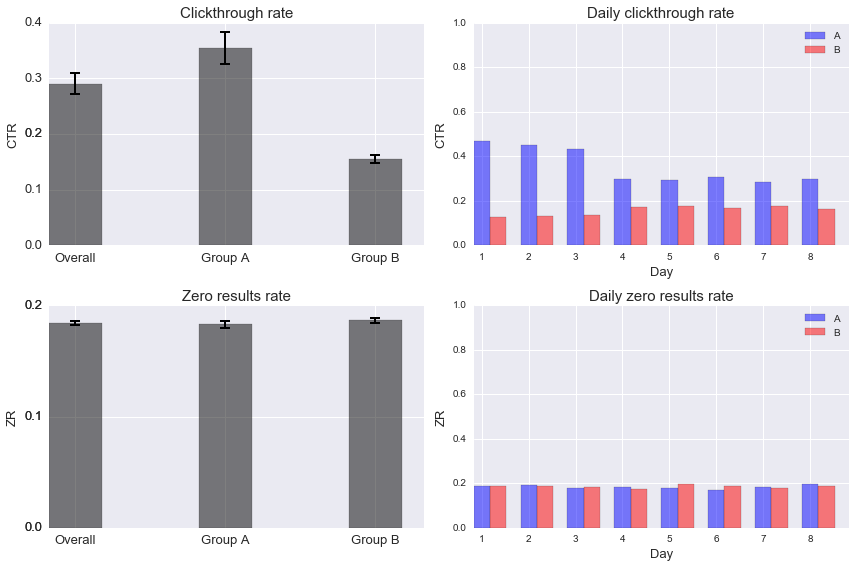

In [39]:
fig = plt.figure(figsize = [12,8])

ax = fig.add_subplot(221)
title = 'Clickthrough rate'
ylabel = 'CTR'
bars(crtMeans, crtErrors, title, ylabel)

ax = fig.add_subplot(222)
title = 'Daily clickthrough rate'
ylabel = 'CTR'
pairs_bars(crtA, crtB, title, ylabel)

ax = fig.add_subplot(223)
title2 = 'Zero results rate'
ylabel2 = 'ZR'
bars(zrMeans, zrErrors, title2, ylabel2)

ax = fig.add_subplot(224)
title2 = 'Daily zero results rate'
ylabel2 = 'ZR'
pairs_bars(zrA, zrB, title2, ylabel2)

plt.tight_layout()
plt.show()

# Session length

In [7]:
b = df[df['group'] == 'b']
b_length = get_session_length(b)

a = df[df['group'] == 'a']
a_length = get_session_length(a)

all_length = get_session_length(df)


In [10]:
sessionMeans, sessionErrors = get_mean_error(all_length.session_lenght_seconds,a_length.session_lenght_seconds,b_length.session_lenght_seconds)

/Library/Python/2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


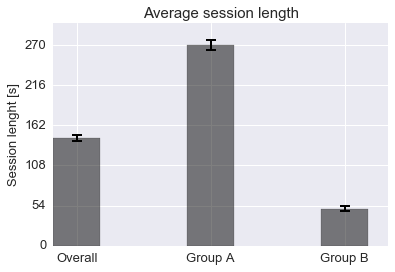

In [9]:
fig = plt.figure(figsize = [6,4])

ax = fig.add_subplot(121)
title = 'Average session length'
ylabel = 'Session lenght [s]'
bars(means, errors, title, ylabel)

ax = fig.add_subplot(122)

ax = fig.add_subplot(121)
title = 'Average session length'
ylabel = 'Session lenght [s]'
bars(means, errors, title, ylabel)



# Hypothesis testing

In [30]:
ttest_ind(a_length.session_lenght_seconds,b_length.session_lenght_seconds, equal_var=False)

(27.953329196018842, 1.9236385541463738e-170)